In [2]:
import sqlite3
import os 

In [11]:
### ENTER YOUR OPEN AI API KEY HERE
os.environ['OPENAI_API_KEY'] = ""

In [3]:
import sqlite3
# In memory

conn = sqlite3.connect(":memory:", check_same_thread = False)

In [3]:
# Create a Local database file

os.makedirs("state_db", exist_ok=True)
db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [5]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import END
from langgraph.graph import MessagesState

In [ ]:
model = ChatOpenAI(model="gpt-4o-mini",temperature=0.2)

In [8]:
class State(MessagesState): 
    summary: str

def call_model(state: State): 
    summaries= state.get("summary","")

    if summaries: 
        system_message=f" Summary of the conversation so far: {summaries}"
        messages=[SystemMessage(content=system_message)] + state['messages']
    else:
        messages= state['messages']

    response=model.invoke(messages)
    return {"messages": response} 

def summarize_converstaion(state:State): 

    summary= state.get("summary","")
    if summary: 

        summary_message=(f"This is the summary of the conversation so far: {summary}\n\n"
        "Extend the summary by taking into account the last message in the conversation.\n\n")

    else: 
        summary_message=" Please Summarize the conversation so far"

    messages= state['messages'] + [HumanMessage(content=summary_message)]
    response=model.invoke(messages)

    delete_messages= [RemoveMessage(id=m.id) for m in state['messages'][:-2]]

    return {"summary": response.content, "messages": delete_messages}

def end_or_summarize(state=State): 

    messages= state['messages']

    if len(messages) > 6:
        return "summarize_converstaion"
    else:
        return END 
                        
        
       



    

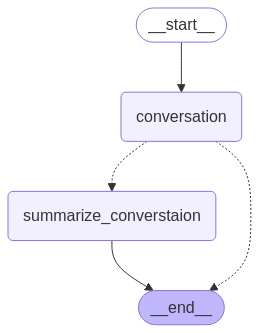

In [9]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

workflow= StateGraph(State) 
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_converstaion)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", end_or_summarize)
workflow.add_edge( "summarize_converstaion",END)


graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
config = {
    "configurable": {
        "thread_id": "1",
        "max_tokens": 10  # Limit output to 10 tokens
    }
}

input_message = HumanMessage(content="Hey, I’ve got a hectic week ahead. Can you remember the tasks I give you to help me stay on track?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()



================================== Ai Message ==================================

I can't remember tasks or information beyond this conversation, but I can help you organize your tasks and suggest ways to keep track of them! You could write them down, use a task management app, or set reminders on your phone. What tasks do you need to manage this week?


In [10]:
input_message = HumanMessage(content="I have a client meeting on Wednesday at 2pm.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Got it! You have a client meeting on Wednesday at 2 PM. Would you like to add any other tasks or details related to this meeting, or do you have more tasks to share?


In [11]:
input_message = HumanMessage(content="No,Thanks. I also need to submit the monthly report by Friday EOD.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Great! So far, you have:

1. **Client meeting** on **Wednesday at 2 PM**.
2. **Submit the monthly report** by **Friday EOD**.

Would you like to add any more tasks or details?


In [12]:
input_message = HumanMessage(content="Sure, my mom’s birthday is on Tuesday. Remind me to buy a gift for her.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()


================================== Ai Message ==================================

Got it! Here’s your updated list:

1. **Client meeting** on **Wednesday at 2 PM**.
2. **Submit the monthly report** by **Friday EOD**.
3. **Buy a gift for your mom's birthday** on **Tuesday**.

If you have more tasks or need help with anything else, just let me know!


In [13]:

config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
print(graph_state)



StateSnapshot(values={'messages': [HumanMessage(content='Sure, my mom’s birthday is on Tuesday. Remind me to buy a gift for her.', additional_kwargs={}, response_metadata={}, id='f1d327b3-74e6-4ab8-a84a-95154435d57e'), AIMessage(content="Got it! Here’s your updated list:\n\n1. **Client meeting** on **Wednesday at 2 PM**.\n2. **Submit the monthly report** by **Friday EOD**.\n3. **Buy a gift for your mom's birthday** on **Tuesday**.\n\nIf you have more tasks or need help with anything else, just let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 249, 'total_tokens': 323, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BJ5vdwl1SjM2kyesM9oGF4SsqYnKY', 'finish_reaso

### Since we have used database like Sqlite it means that the state has been saved.

#### For example, even if I restart the notebook kernel, it should have the same state loaded in the SQL DB on local disk 

In [10]:

config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
print(graph_state)

StateSnapshot(values={'messages': [HumanMessage(content='Sure, my mom’s birthday is on Tuesday. Remind me to buy a gift for her.', additional_kwargs={}, response_metadata={}, id='f1d327b3-74e6-4ab8-a84a-95154435d57e'), AIMessage(content="Got it! Here’s your updated list:\n\n1. **Client meeting** on **Wednesday at 2 PM**.\n2. **Submit the monthly report** by **Friday EOD**.\n3. **Buy a gift for your mom's birthday** on **Tuesday**.\n\nIf you have more tasks or need help with anything else, just let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 249, 'total_tokens': 323, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BJ5vdwl1SjM2kyesM9oGF4SsqYnKY', 'finish_reaso